In [13]:
from dotenv import dotenv_values
from openai import OpenAI
from IPython.display import Markdown, Image
import fitz  # PyMuPDF
import base64
import instructor
from pydantic import BaseModel, create_model
import csv
import os
import json

In [14]:
env = dotenv_values(".env")

openai_client = OpenAI(api_key=env["OPENAI_API_KEY"])

In [ ]:
def prepare_image_for_open_ai(image_path):
    with open(image_path, "rb") as f:
        image_data = base64.b64encode(f.read()).decode('utf-8')

    return f"data:image/png;base64,{image_data}"

def convert_pdf_to_png(pdf_path, output_path, zoom_x=3, zoom_y=3):
    # Otwórz plik PDF
    pdf_document = fitz.open(pdf_path)
    
    # Iteruj przez każdą stronę
    for page_num in range(len(pdf_document)):
        # Pobierz stronę
        page = pdf_document.load_page(page_num)
        
        # Ustaw współczynnik powiększenia dla wyższej rozdzielczości
        mat = fitz.Matrix(zoom_x, zoom_y)
        
        # Renderuj stronę jako obraz (pixmap) z określonym współczynnikiem powiększenia
        pix = page.get_pixmap(matrix=mat)
        
        # Zapisz obraz jako PNG
        pix.save(f"{output_path}.png")

In [16]:
pdf_path = '600.100.00.04_05.05.PDF'
filename = pdf_path
if pdf_path.endswith(".PDF"):
    filename = pdf_path.rstrip(".PDF")
output_path = f"{filename}"
convert_pdf_to_png(pdf_path, output_path)

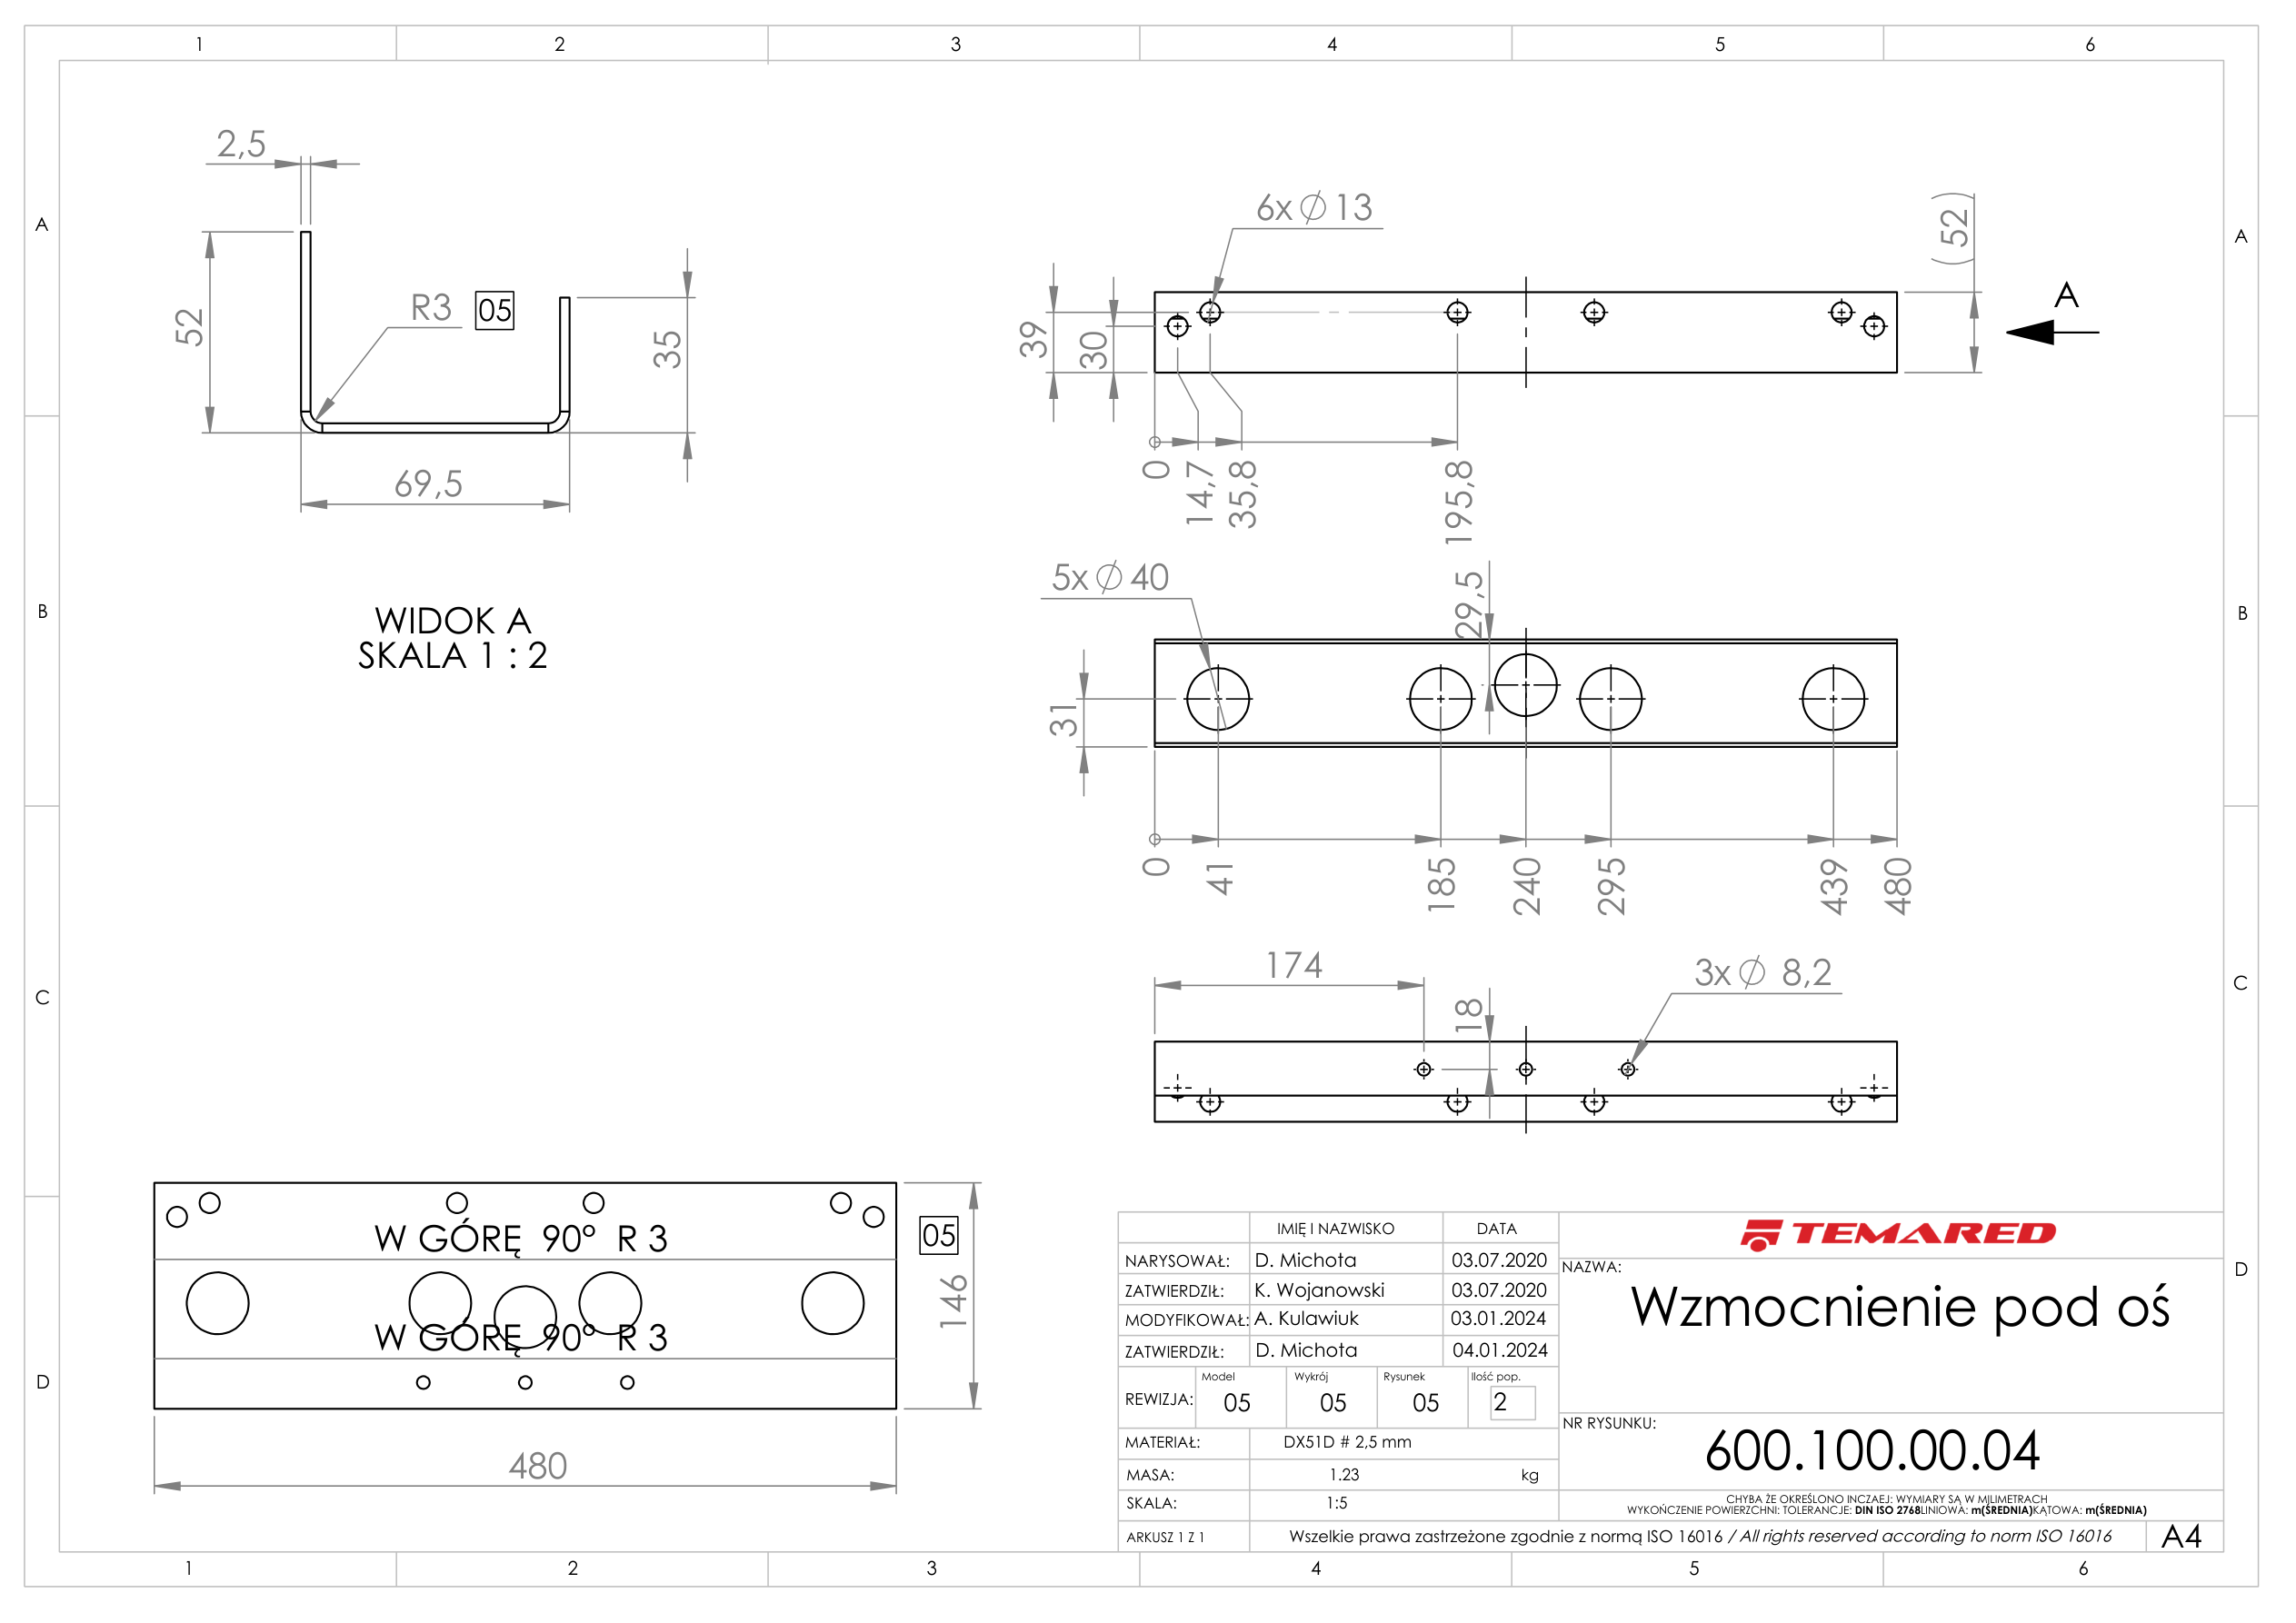

In [17]:
Image(f"{output_path}.png")

In [18]:
instructor_openai_client = instructor.from_openai(openai_client)

In [ ]:
def read_data_from_document(pdf_document):
    instructor_openai_client = instructor.from_openai(openai_client)

    class ImageInfo(BaseModel):
        drawing_number: str
        name: str
        height_before_bending: float
        width_before_bending: float
        model: int
        pattern: int
        drawing: int
        nums_of_corr: int
        material: str
        thickness: float
        bending_radius: float
        mass: float
        additional_note: str
        number_of_bends: int

    info = instructor_openai_client.chat.completions.create(
        model="gpt-4o",
        response_model=ImageInfo,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Odczytaj z rysunku technicznego elementu giętego z blachy następujące parametry, Nr rysunku, nazwa, wysokość przed gięciem wymiar odczytaj z rozwinięcia z tego samego rzutu co szerokość, szerokość przed gięciem wymiar odczytaj z rozwinięciu z tego samego rzutu co wysokość, model, wykrój, rysunek, ilość pop, Materiał (gatunek bez grubości), grubość blachy, Promień gięcia, Masa, dodatkowa treść po słowie 'Uwaga' jeśli taka występuje. Z rzutu przekroju odczytaj ile element ma gięć.",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": pdf_document,
                            "detail": "high"
                        },
                    },
                ],
            },
        ],
        seed = 1
    )

    info.model_dump()


{'drawing_number': '600.100.00.04',
 'name': 'Wzmocnienie pod oś',
 'height_before_bending': 480.0,
 'width_before_bending': 146.0,
 'model': 5,
 'pattern': 5,
 'drawing': 5,
 'nums_of_corr': 2,
 'material': 'DX51D',
 'thickness': 2.5,
 'bending_radius': 3.0,
 'mass': 1.23,
 'additional_note': 'Brak',
 'number_of_bends': 2}

In [ ]:
dane_list = info.model_dump()
dane = [dane_list]

nazwa_pliku = "dane.csv"

# Sprawdzenie, czy plik istnieje
plik_istnieje = os.path.isfile(nazwa_pliku)

# Zestaw do przechowywania unikalnych kombinacji "drawing_number", "pattern", "drawing"
unikalne_dane = set()

# Odczyt istniejących danych, jeśli plik istnieje
if plik_istnieje:
    with open(nazwa_pliku, mode='r', newline='') as plik:
        reader = csv.DictReader(plik)
        for wiersz in reader:
            unikalne_dane.add((wiersz['drawing_number'], int(wiersz['pattern']), int(wiersz['drawing'])))

# Otwarcie pliku w trybie dopisywania, jeśli istnieje, lub zapisu, jeśli nie istnieje
with open(nazwa_pliku, mode='a' if plik_istnieje else 'w', newline='') as plik:
    fieldnames = ['drawing_number', 'name', 'height_before_bending', 'width_before_bending', 'model', 
                  'pattern', 'drawing', 'nums_of_corr', 'material', 'thickness', 
                  'bending_radius', 'mass', 'additional_note', 'number_of_bends']
    writer = csv.DictWriter(plik, fieldnames=fieldnames)
    
    # Jeśli plik nie istnieje, zapisz nagłówki
    if not plik_istnieje:
        writer.writeheader()
    
    # Zapis danych do pliku CSV z kontrolą duplikatów
    for wiersz in dane:
        klucz = (wiersz['drawing_number'], wiersz['pattern'], wiersz['drawing'])
        if klucz in unikalne_dane:
            print(f"Duplikat znaleziony: {wiersz}")
        else:
            writer.writerow(wiersz)
            unikalne_dane.add(klucz)

print(f"Dane zostały zapisane do pliku {nazwa_pliku}")

Duplikat znaleziony: {'drawing_number': '600.100.00.04', 'name': 'Wzmocnienie pod oś', 'height_before_bending': 480.0, 'width_before_bending': 146.0, 'model': 5, 'pattern': 5, 'drawing': 5, 'nums_of_corr': 2, 'material': 'DX51D', 'thickness': 2.5, 'bending_radius': 3.0, 'mass': 1.23, 'additional_note': 'Brak', 'number_of_bends': 2}
Dane zostały zapisane do pliku dane.csv
